<a href="https://colab.research.google.com/github/alessiatani02/Handwritten-3D-Digit-Pattern-Recognition/blob/main/pattern_rec_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### 1. Preprocessing pipeline

In [ ]:
import numpy as np
from typing import List, Tuple

class preprocessing_pipeline:
    """
    Preprocessing pipeline for 3D trajectories
    """
    def __init__(self, resample_size: int):
        self.resample_size = resample_size

    def translate_to_origin(self, X: List[np.ndarray]) -> List[np.ndarray]:
        """
        Translates trajectories to the origin.
        """
        n_samples = len(X)

        for i in range(n_samples):
            X[i] = X[i] - X[i][0]

        return X

    def segment_lengths_acc(self, X: List[np.ndarray]) -> List[np.ndarray]:
        """
        Calculates the accumulated length of each segment.
        """
        n_samples = len(X)
        segment_lengths = []

        for i in range(n_samples):
            segment_lengths.append(np.linalg.norm(np.diff(X[i], axis=0), axis=1))
            segment_lengths[i] = np.cumsum(segment_lengths[i])
        return segment_lengths


    def scale(self, X: List[np.ndarray], segment_lengths: List[np.ndarray]) -> Tuple[List[np.ndarray],List[np.ndarray]]:
        """
        Scales trajectories to unit length.
        """
        n_samples = len(X)
        X_scaled = []
        segment_lengths_scaled = []

        for i in range(n_samples):
            X_scaled.append(X[i] / segment_lengths[i][-1])
            segment_lengths_scaled.append(segment_lengths[i] / segment_lengths[i][-1])

        return X_scaled, segment_lengths_scaled

    def re_sampling(self, X: List[np.ndarray], segment_lengths: List[np.ndarray]) -> np.ndarray:
        """
        Resamples trajectories to a fixed number of points with linear interpolation.
        """
        n_samples = len(X)
        X_resampled = np.zeros((n_samples, self.resample_size, 3))

        delta_S = 1.0 / (self.resample_size - 1)

        for i in range(n_samples):
            n_coords = len(X[i])

            s_orig = np.zeros(n_coords)
            s_orig[1:] = segment_lengths[i]

            Xi = X[i]

            for k in range(self.resample_size):
                s = k * delta_S

                # if at or before the beginning
                if s <= 0.0:
                    X_resampled[i, k] = Xi[0]
                    continue

                # if at or beyond the end
                if s >= s_orig[-1]:
                    X_resampled[i, k] = Xi[-1]
                    continue

                # find t such that s_orig[t] <= s < s_orig[t+1]
                t = np.searchsorted(s_orig, s) - 1
                if t < 0:
                    t = 0
                if t >= n_coords - 1:
                    t = n_coords - 2

                s0 = s_orig[t]
                s1 = s_orig[t + 1]
                X0 = Xi[t]
                X1 = Xi[t + 1]

                # handle zero-length segment
                if s1 == s0:
                    X_resampled[i, k] = X0
                    continue

                # linear interpolation
                alpha = (s - s0) / (s1 - s0)
                X_resampled[i, k] = (1.0 - alpha) * X0 + alpha * X1

        return X_resampled

    def velocities(self, X: np.ndarray) -> np.ndarray:
        """
        Calculates the velocities of the trajectories.
        """
        n_samples = X.shape[0]
        n_coords = X.shape[1]
        V = np.zeros((n_samples, n_coords - 1, 3))
        for i in range(n_samples):
            V[i] = np.diff(X[i], axis=0)
        return V

    def concatenate(self, X: np.ndarray, V: np.ndarray) -> np.ndarray:
        """
        Concatenates trajectories and velocities.
        """
        n_samples = X.shape[0]
        n_coords = X.shape[1]
        X_processed = np.zeros((n_samples, 6 * n_coords - 3))
        for i in range(n_samples):
            X_processed[i, :3 * n_coords] = X[i].flatten()
            X_processed[i, 3 * n_coords:] = V[i].flatten()
        return X_processed

    def transform(self, X: List[np.ndarray]) -> np.ndarray:
        """
        Applies the full preprocessing pipeline to 3D trajectories.
        """
        X_proc = X.copy()
        X_proc = self.translate_to_origin(X_proc)
        segment_lengths = self.segment_lengths_acc(X_proc)
        X_scaled, segment_lengths_scaled = self.scale(X_proc, segment_lengths)
        X_resampled = self.re_sampling(X_scaled, segment_lengths_scaled)
        V = self.velocities(X_resampled)
        X_processed = self.concatenate(X_resampled, V)
        return X_processed

### 2. Scaler for standard normalization

In [ ]:
class Scaler:
    """
    A simple StandardScaler-like class for standard normalization.
    """
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X: np.ndarray) -> 'Scaler':
        """
        Computes the mean and standard deviation for each feature in X.
        """
        if X.ndim == 1:
            X = X.reshape(1, -1)

        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        # Avoid division by zero for features with zero standard deviation
        self.std[self.std == 0] = 1.0
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Performs standard normalization on X using the fitted mean and standard deviation.
        """
        if self.mean is None or self.std is None:
            raise RuntimeError("Scaler not fitted. Call .fit() first.")
        if X.ndim == 1:
            X = X.reshape(1, -1)

        return (X - self.mean) / self.std

### 3. Non-linear SVM implementation

In [ ]:
from typing import Optional, Literal

class SVM_SMO:
    """
    Support Vector Machine with Sequential Minimal Optimization (SMO) and RBF kernel.
    """
    def __init__(
        self,
        kernel_type: Literal['rbf', 'linear', 'poly'] = 'linear',
        C: float = 1.0,
        gamma: float = 0.1,
        eps: float = 1e-3,
        max_passes: int = 5,
        random_state: Optional[int] = None,
        degree: int = 3
    ):
        """
        Parameters:
        ----------
        kernel_type : str, optional
            Type of kernel to use. Can be 'rbf' or 'linear'
        C : float
            Regularization parameter
        gamma : float
            Kernel parameter
        eps : float
            Numerical precision
        max_passes : int
            Maximum number of passes without changes
        random_state : int, optional
            Seed for reproducibility
        """
        self.kernel_type = kernel_type
        self.C = C
        self.gamma = gamma
        self.eps = eps
        self.max_passes = max_passes
        self.random_state = random_state
        self.degree = degree

        # Set Random Seed
        if random_state is not None:
            np.random.seed(random_state)

        # Model parameters (after training)
        self.alphas = None
        self.b = 0.0
        self.X = None
        self.y = None
        self.error_cache = None
        self.rng = np.random.RandomState(random_state)

    def kernel(self, X1: np.ndarray, X2: np.ndarray) -> np.ndarray:
        """Calculates gaussian rbf kernel function K(X1, X2)"""
        if X1.ndim == 1:
            X1 = X1.reshape(1, -1)
        if X2.ndim == 1:
            X2 = X2.reshape(1, -1)
        if self.kernel_type == 'linear':
            # Linear kernel: x1^T * x2
            return X1 @ X2.T
        elif self.kernel_type == 'rbf':
            # ||x1 - x2||^2 = ||x1||^2 + ||x2||^2 - 2 * x1^T * x^2
            sq_dist = np.sum(X1**2, axis=1, keepdims=True) + np.sum(X2**2, axis=1) - 2 * X1@X2.T
            return np.exp(-self.gamma * sq_dist)
        elif self.kernel_type == 'poly':
            # Polynomial kernel: (x1^T * x2 + 1)^degree
            return (X1 @ X2.T + 1)**self.degree

    def compute_output(self, i: int) -> float:
        """Calculates SVM output u_i for example i"""
        kernel_vals = self.kernel(self.X, self.X[i]).flatten()
        return np.sum(self.alphas * self.y * kernel_vals) - self.b

    def compute_error(self, i: int) -> float:
        """Calculates error E_i = u_i - y_i"""
        return self.compute_output(i) - self.y[i]

    def compute_bounds(self, i1: int, i2: int) -> Tuple[float, float]:
        """Calculates L and H bounds for alpha_2"""
        if self.y[i1] != self.y[i2]:
            L = max(0.0, self.alphas[i2] - self.alphas[i1])
            H = min(self.C, self.C + self.alphas[i2] - self.alphas[i1])
        else:
            L = max(0.0, self.alphas[i2] + self.alphas[i1] - self.C)
            H = min(self.C, self.alphas[i2] + self.alphas[i1])
        return L, H

    def take_step(self, i1: int, i2: int) -> bool:
        """
        Optimizes two Lagrange multipliers.
        Returns True if progress was made.
        """
        if i1 == i2:
            return False

        a1 = self.alphas[i1]
        a2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self.error_cache[i1]
        E2 = self.error_cache[i2]
        s = y1 * y2

        # Calculate bounds L and H
        L, H = self.compute_bounds(i1, i2)
        if L == H:
            return False

        # Calculate second derivative eta
        k11 = self.kernel(self.X[i1].reshape(1, -1), self.X[i1].reshape(1, -1))[0, 0]
        k12 = self.kernel(self.X[i1].reshape(1, -1), self.X[i2].reshape(1, -1))[0, 0]
        k22 = self.kernel(self.X[i2].reshape(1, -1), self.X[i2].reshape(1, -1))[0, 0]
        eta = k11 + k22 - 2 * k12

        if eta > 0:
            # Normal case: eta > 0
            # Calculate new alpha_2
            a2_new = a2 + y2 * (E1 - E2) / eta

            # Clip to [L, H]
            if a2_new >= H:
                a2_new = H
            elif a2_new <= L:
                a2_new = L
        else:
            # Unusual case: evaluate objective function at the endpoints
            # This calculation makes use of the errors already being calculated
            # so that we do not have to evaluate the kernel values again
            f1 = y1 * (E1 + self.b) - a1 * k11 - s * a2 * k12
            f2 = y2 * (E2 + self.b) - s * a1 * k12 - a2 * k22
            L1 = a1 + s * (a2 - L)
            H1 = a1 + s * (a2 - H)
            Lobj = L1 * f1 + L * f2 + 0.5 * (L1 ** 2) * k11 + 0.5 * (L ** 2) * k22 + s * L * L1 * k12
            Hobj = H1 * f1 + H * f2 + 0.5 * (H1 ** 2) * k11 + 0.5 * (H ** 2) * k22 + s * H * H1 * k12

            if Lobj < Hobj - self.eps:
                a2_new = L
            elif Lobj > Hobj + self.eps:
                a2_new = H
            else:
                a2_new = a2

        # Check if change is significant
        if abs(a2_new - a2) < self.eps * (a2_new + a2 + self.eps):
            return False

        # Calculate new alpha_1
        a1_new = a1 + s * (a2 - a2_new)

        # Update alphas first
        self.alphas[i1] = a1_new
        self.alphas[i2] = a2_new

        # Update threshold b
        b1 = E1 + y1 * (a1_new - a1) * k11 + y2 * (a2_new - a2) * k12 + self.b
        b2 = E2 + y1 * (a1_new - a1) * k12 + y2 * (a2_new - a2) * k22 + self.b

        b_old = self.b
        if 0 < a1_new < self.C:
            self.b = b1
        elif 0 < a2_new < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2

        delta_b = self.b - b_old

        # Update error cache only for non-bound examples since they are most likely to be picked by the algorithm
        for i in range(len(self.y)):
            if 0 < self.alphas[i] < self.C:
                # Update Error Cache precisely for the newly calculated alphas
                if i == i1 or i == i2:
                    self.error_cache[i] = self.compute_error(i)
                # Incrementally update errors based on the change of the two alphas
                else:
                    k1i = self.kernel(self.X[i1].reshape(1, -1), self.X[i].reshape(1, -1))[0, 0]
                    k2i = self.kernel(self.X[i2].reshape(1, -1), self.X[i].reshape(1, -1))[0, 0]
                    self.error_cache[i] += y1 * (a1_new - a1) * k1i + y2 * (a2_new - a2) * k2i - delta_b

        return True

    def examine_example(self, i2: int) -> bool:
        """
        Examines an example and tries to optimize it.
        """
        y2 = self.y[i2]
        a2 = self.alphas[i2]
        E2 = self.error_cache[i2]
        r2 = E2 * y2

        # Check KKT conditions
        if (r2 < -self.eps and a2 < self.C) or (r2 > self.eps and a2 > 0):
            # KKT condition violated -> a2 can be optimized further

            # Heuristic 1: Choose i1 to maximize |E1 - E2| -> leads to biggest update for a2
            non_bound_indices = np.where((self.alphas > 0) & (self.alphas < self.C))[0]

            if len(non_bound_indices) > 1:
                # Choose i1 that approximately maximizes |E1 - E2|
                if E2 > 0:
                    i1 = self.error_cache[non_bound_indices].argmin()
                    i1 = non_bound_indices[i1]
                else:
                    i1 = self.error_cache[non_bound_indices].argmax()
                    i1 = non_bound_indices[i1]

                if self.take_step(i1, i2):
                    return True

            # Heuristic 2: Iterate over non-bound examples
            if len(non_bound_indices) > 0:
                # Start at random point everytime
                start_idx = self.rng.randint(len(non_bound_indices))
                for i1 in np.roll(non_bound_indices, start_idx):
                    if self.take_step(i1, i2):
                        return True

            # Heuristic 3: Iterate over all examples
            all_indices = np.arange(len(self.y))
            # Start at random point everytime
            start_idx = self.rng.randint(len(self.y))
            for i1 in np.roll(all_indices, start_idx):
                if self.take_step(i1, i2):
                    return True

        return False

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'SVM_SMO':
        """
        Trains the SVM using the SMO algorithm.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Labels (+1 or -1)
        """

        n_samples = X.shape[0]

        # Initialization
        self.X = X
        self.y = y
        self.alphas = np.zeros(n_samples)
        self.b = 0.0
        self.error_cache = -y.copy()  # Initial errors

        # Main training loop
        num_changed = 0
        examine_all = True
        passes = 0
        iteration = 0

        while (num_changed > 0 or examine_all):
            # Reset number of updates to 0
            num_changed = 0

            if examine_all:
                # Iterate over all examples
                for i in range(n_samples):
                    num_changed += self.examine_example(i)
            else:
                # Iterate only over non-bound examples
                non_bound = np.where((self.alphas > 0) & (self.alphas < self.C))[0]
                for i in non_bound:
                    num_changed += self.examine_example(i)

            # If last round went over all examples only go over the non-bound examples next
            if examine_all:
                examine_all = False
            # If the number of updates in the last round was 0 go over all examples again
            elif num_changed == 0:
                examine_all = True
                passes += 1
                # if no progress was made 5 times in a row terminate algorithm
                if passes >= self.max_passes:
                    break
            else:
                passes = 0

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts for new data.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Test data

        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Predicted labels (+1 or -1)
        """

        # General kernel calculation
        K = self.kernel(self.X, X)
        scores = np.sum((self.alphas * self.y).reshape(-1, 1) * K, axis=0) - self.b

        return np.where(scores >= 0, 1, -1)

    def get_support_vectors(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Returns the support vectors, their corresponding labels, and alphas.

        Returns:
        --------
        support_vectors : np.ndarray
            The feature vectors of the support vectors.
        sv_labels : np.ndarray
            The labels of the support vectors.
        sv_alphas : np.ndarray
            The alpha values corresponding to the support vectors.
        """
        if self.alphas is None or self.X is None or self.y is None:
            raise RuntimeError("Model has not been fitted yet. Call .fit() first.")

        # Define a small epsilon specifically for checking non-zero alphas for support vectors
        # This should be smaller than the general self.eps used for convergence to avoid filtering valid SVs
        sv_epsilon = 1e-6 # A common practice is to use a smaller value like 1e-6 or 1e-7

        # Find indices where alphas are non-zero (greater than the dedicated sv_epsilon)
        support_vector_indices = np.where(self.alphas > sv_epsilon)[0]

        support_vectors = self.X[support_vector_indices]
        sv_labels = self.y[support_vector_indices]
        sv_alphas = self.alphas[support_vector_indices]

        return support_vectors, sv_labels, sv_alphas

### 4. Multiclass OvO SVM

In [ ]:
from itertools import combinations

class OvO_SVM:
    """
    One-vs-One Multi-Class Classifier for rbf_SVM.

    Trains N*(N-1)/2 binary classifiers for N classes,
    where every classifier decides between two classes.
    """

    def __init__(self, **classifier_params):
        """
        Args:
            **classifier_params: parameters for the initialization of the classifiers
        """
        self.classifier_class = SVM_SMO
        self.classifier_params = classifier_params
        self.classifiers = []
        self.class_pairs = []
        self.classes_ = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'OvO_SVM':
        """
        Trains all binary classifiers.

        Args:
            X: Feature matrix (n_samples, n_features)
            y: Label vector (n_samples,)

        Returns:s
            self
        """
        self.classes = np.unique(y)

        if len(self.classes) < 2:
            raise ValueError("y must include at least 2 different class labels")

        # Create all possible combinations of two classes
        self.class_pairs = list(combinations(self.classes, 2))
        self.classifiers = []

        for class_i, class_j in self.class_pairs:
            # Select only data points of classes i and j
            mask = (y == class_i) | (y == class_j)
            X_filtered = X[mask]
            y_filtered = y[mask]

            # Transform class labels into -1 and 1
            y_binary = np.where(y_filtered == class_i, 1, -1)

            # Initialize and train binary classifier
            clf = self.classifier_class(**self.classifier_params)
            clf.fit(X_filtered, y_binary)
            self.classifiers.append(clf)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Prediction through vote of all binary classifiers.

        Args:
            X: Feature matrix (n_samples, n_features)

        Returns:
            Predicted labels (n_samples,)
        """
        # Handle single sample input (1D array) by reshaping it to 2D
        if X.ndim == 1:
            X = X.reshape(1, -1)
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        votes = np.zeros((n_samples, n_classes), dtype=int)

        for clf, (class_i, class_j) in zip(self.classifiers, self.class_pairs):
            predictions = clf.predict(X)
            votes[predictions == 1, class_i] += 1
            votes[predictions == -1, class_j] += 1

        # class with most votes gets selected for each sample
        winning_indices = np.argmax(votes, axis=1)
        return self.classes[winning_indices]

### 5. Train/Test-Split method

In [ ]:
import numpy as np
from typing import Union

def train_test_split(X: np.ndarray, y: np.ndarray, test_size: float = 0.3, random_state: Union[int, None] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Splits data into random train and test subsets.

    Parameters:
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        The input features.
    y : np.ndarray, shape (n_samples,)
        The target labels.
    test_size : float, optional
        The proportion of the dataset to include in the test split. Default is 0.3.
    random_state : int or None, optional
        Controls the shuffling applied to the data before applying the split. Default is None.

    Returns:
    --------
    X_train : np.ndarray
        Training features.
    X_test : np.ndarray
        Testing features.
    y_train : np.ndarray
        Training labels.
    y_test : np.ndarray
        Testing labels.
    """
    if not (0 < test_size < 1):
        raise ValueError("test_size must be a float between 0 and 1.")
    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of samples.")

    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    n_train = n_samples - n_test

    indices = np.arange(n_samples)

    if random_state is not None:
        rng = np.random.RandomState(random_state)
        rng.shuffle(indices)
    else:
        np.random.shuffle(indices)

    train_indices = indices[:n_train]
    test_indices = indices[n_train:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

### 6. Import Data

In [ ]:
import os
import pandas as pd

path_to_directory = '/content/drive/MyDrive/Pattern Recognition/Project/training_data'
samples = []
labels = []

trajectory_lengths = []
for filename in os.listdir(path_to_directory):
    if filename.endswith('.csv'): # Check if the file is a CSV
        filepath = os.path.join(path_to_directory, filename)
        try:
            df = pd.read_csv(filepath, header=None)
            sample_array = df.to_numpy()
            trajectory_lengths.append(sample_array.shape[0])
            samples.append(sample_array)
            label = filename.split('_')[1]
            labels.append(int(label))
        except Exception as e:
            print(f"Error loading {filename}: {e}")

y = np.array(labels, dtype=int)
mean_trajectory_length = np.mean(trajectory_lengths)
print(f"Mean trajectory length: {mean_trajectory_length}")

Mean trajectory length: 55.25


### 7. Run preprocessing pipeline on samples

In [ ]:
# Using the mean trajectory length as the resample size
pipeline = preprocessing_pipeline(int(mean_trajectory_length))
X = pipeline.transform(samples)

### 8. Splitting the data into train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### 9. Run k-fold cross validation to find best hyperparameters

In [ ]:
from sklearn.model_selection import KFold

C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
#gamma_values = [0.001, 0.01, 0.1, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_C = None
best_gamma = None

results = []

scaler = Scaler()

for C in C_values:
    #for gamma in gamma_values:
        fold_accuracies = []
        print(f"\nTesting C={C}")

        for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Scale data within the fold
            #scaler.fit(X_train_fold)
            #X_train_fold_scaled = scaler.transform(X_train_fold)
            #X_val_fold_scaled = scaler.transform(X_val_fold)

            # Train OvO_SVM
            clf = OvO_SVM(C=C, random_state=42)
            clf.fit(X_train_fold, y_train_fold)

            # Predict and evaluate
            y_pred_fold = clf.predict(X_val_fold)
            accuracy_fold = np.mean(y_pred_fold == y_val_fold)
            fold_accuracies.append(accuracy_fold)
            print(f"  Fold {fold+1} Accuracy: {accuracy_fold:.4f}")

        avg_accuracy = np.mean(fold_accuracies)
        results.append({"C": C, "avg_accuracy": avg_accuracy, "fold_accuracies": fold_accuracies})
        print(f"  Average Accuracy for C={C}: {avg_accuracy:.4f}")

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_C = C
            #best_gamma = gamma

print(f"\nBest Hyperparameters: C={best_C} with Average Accuracy: {best_accuracy:.4f}")


Testing C=0.0001
  Fold 1 Accuracy: 0.9357
  Fold 2 Accuracy: 0.9357
  Fold 3 Accuracy: 0.9071
  Fold 4 Accuracy: 0.9000
  Fold 5 Accuracy: 0.9357
  Average Accuracy for C=0.0001: 0.9229

Testing C=0.001
  Fold 1 Accuracy: 0.9357
  Fold 2 Accuracy: 0.9357
  Fold 3 Accuracy: 0.9071
  Fold 4 Accuracy: 0.9000
  Fold 5 Accuracy: 0.9357
  Average Accuracy for C=0.001: 0.9229

Testing C=0.01
  Fold 1 Accuracy: 0.9357
  Fold 2 Accuracy: 0.9357
  Fold 3 Accuracy: 0.9071
  Fold 4 Accuracy: 0.9000
  Fold 5 Accuracy: 0.9357
  Average Accuracy for C=0.01: 0.9229

Testing C=0.1
  Fold 1 Accuracy: 0.8500
  Fold 2 Accuracy: 0.9357
  Fold 3 Accuracy: 0.8929
  Fold 4 Accuracy: 0.9000
  Fold 5 Accuracy: 0.9214
  Average Accuracy for C=0.1: 0.9000

Testing C=1
  Fold 1 Accuracy: 0.8071
  Fold 2 Accuracy: 0.8357
  Fold 3 Accuracy: 0.8643
  Fold 4 Accuracy: 0.8571
  Fold 5 Accuracy: 0.7643
  Average Accuracy for C=1: 0.8257

Testing C=10
  Fold 1 Accuracy: 0.9571
  Fold 2 Accuracy: 0.9357
  Fold 3 Accurac

### 10. Train model on best hyperparameters

In [ ]:
#best_C = 0.0001
#best_gamma = 1
final_clf = OvO_SVM(kernel_type = 'rbf', C=0.1, gamma=0.01, random_state=42)
scaler = Scaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
final_clf.fit(X_train_scaled, y_train)
y_train_pred = final_clf.predict(X_train_scaled)
y_test_pred = final_clf.predict(X_test_scaled)

### 11. Evaluate model performance

Classification Report on train set:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        71
           1       1.00      0.99      0.99        70
           2       0.99      1.00      0.99        69
           3       1.00      1.00      1.00        70
           4       1.00      0.99      0.99        73
           5       1.00      1.00      1.00        75
           6       1.00      0.91      0.95        69
           7       1.00      1.00      1.00        65
           8       1.00      1.00      1.00        74
           9       0.98      1.00      0.99        64

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700

Confusion Matrix:
[[71  0  0  0  0  0  0  0  0  0]
 [ 0 69  1  0  0  0  0  0  0  0]
 [ 0  0 69  0  0  0  0  0  0  0]
 [ 0  0  0 70  0  0  0  0  0  0]
 [ 0  0  0  0 72  0  0  0  0  1]
 [ 0  0  0  0  0 75  0

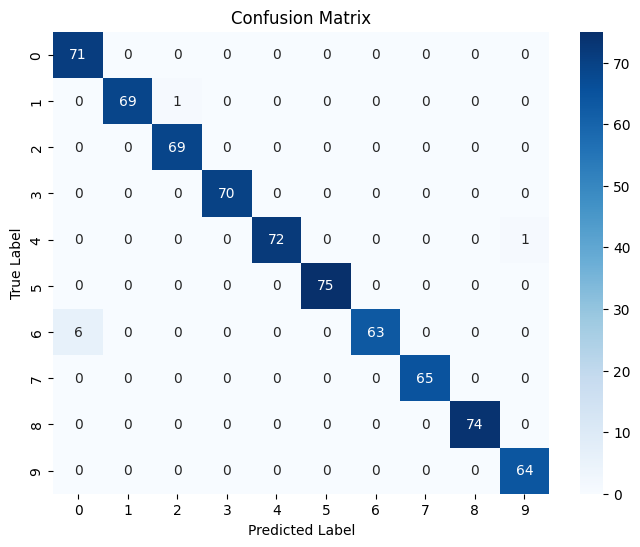

Classification Report on test set:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        29
           1       0.93      0.93      0.93        30
           2       0.91      1.00      0.95        31
           3       1.00      0.93      0.97        30
           4       1.00      0.93      0.96        27
           5       0.89      0.96      0.92        25
           6       1.00      0.81      0.89        31
           7       1.00      0.89      0.94        35
           8       0.96      1.00      0.98        26
           9       0.95      1.00      0.97        36

    accuracy                           0.94       300
   macro avg       0.95      0.94      0.94       300
weighted avg       0.95      0.94      0.94       300

Confusion Matrix:
[[29  0  0  0  0  0  0  0  0  0]
 [ 1 28  0  0  0  1  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  1 28  0  1  0  0  0  0]
 [ 0  1  0  0 25  0  0  0  0  1]
 [ 0  0  0  0  0 24  0 

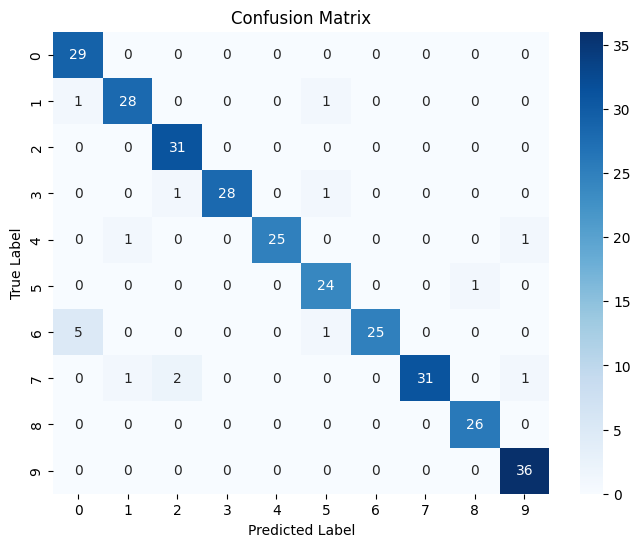

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification Report on train set:")
print(classification_report(y_train, y_train_pred, target_names=[str(i) for i in range(len(np.unique(y)))]))

conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(len(np.unique(y)))],
            yticklabels=[str(i) for i in range(len(np.unique(y)))])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report on test set:")
print(classification_report(y_test, y_test_pred, target_names=[str(i) for i in range(len(np.unique(y)))]))

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(len(np.unique(y)))],
            yticklabels=[str(i) for i in range(len(np.unique(y)))])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 12. Final prediction function for project

In [ ]:
def digit_classify(test_sample: np.ndarray) -> int:
    """
    Predicts digit for single sample
    """
    if test_sample.ndim == 3:
        raise ValueError("Method can only be called for single sample")
    test_sample_transformed = pipeline.transform([test_sample])
    test_sample_scaled = scaler.transform(test_sample_transformed)
    prediction = final_clf.predict(test_sample_scaled)
    return prediction[0]

In [ ]:
i = np.random.randint(1000)
pred = digit_classify(samples[i])
true = y[i]
print(f"Predicted: {pred}, True: {true}")

Predicted: 7, True: 7
